In [46]:

%matplotlib inline
from itertools import chain, combinations
import matplotlib
import json
import arviz

import importlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
from abc import ABC
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import nest_asyncio
nest_asyncio.apply()
from collections import defaultdict
from typing import Any

from sklearn import metrics
from matplotlib import pyplot as plt


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.bijectors as tfb

# pip install github:https://github.com/mederrata/bayesianquilts
from bayesianquilts.models.logistic_regression_reparam import LogisticRegression2
from bayesianquilts.metrics.classification import classification_metrics, auroc, auprc
from bayesianquilts.sampler import psis, nppsis


2024-12-15 03:51:12.931031: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 03:51:12.933612: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 03:51:12.940920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734234672.953751 3156539 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734234672.957386 3156539 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 03:51:12.970832: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [12]:
df = pd.read_table(importlib.resources.path('bayesianquilts', 'data')/"enset.csv", header=None, names=['d10', 'kg'], sep=",")

<Axes: xlabel='d10', ylabel='kg'>

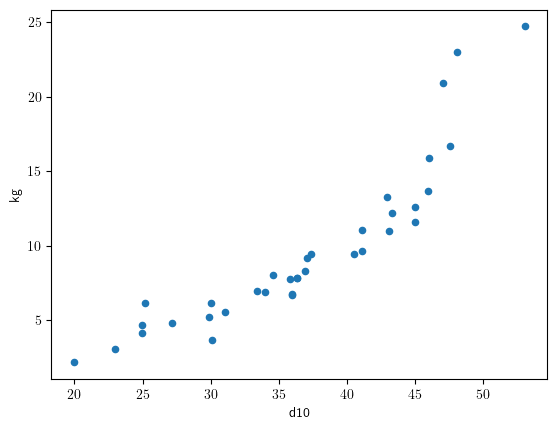

In [18]:
df.plot.scatter(x='d10', y='kg')

In [22]:
powerlaw_code = """
data {
  int <lower=0> N;                // number  of  observations
  vector[N] log_kg;      // outputs
  vector[N] log_d10;      // outputs
}

parameters {
  real  b0;
  real  b1;
  real<lower=0> sigma;
  }
  
model {
    vector[N] mu; 
    sigma ~ cauchy(0, 5); 
    b0 ~ normal(0, 5);
    b1 ~ normal(0, 5);
    mu = b0 + b1 * log_d10; 
    log_kg ~ normal(mu, sigma);
    
}

"""

with open(f"/tmp/loglog.stan", 'w') as f:
  f.writelines(powerlaw_code)

In [23]:
sm = CmdStanModel(stan_file="/tmp/loglog.stan")

04:03:37 - cmdstanpy - INFO - compiling stan file /tmp/loglog.stan to exe file /tmp/loglog


04:03:53 - cmdstanpy - INFO - compiled model executable: /tmp/loglog


In [36]:
np.log(df.iloc[:, 0].values).tolist()

[2.994220557468669,
 3.1351000754786686,
 3.2261004198078314,
 3.217061491137961,
 3.217061491137961,
 3.301193423840597,
 3.4042139752015808,
 3.3966553602276544,
 3.4363234267099942,
 3.4017007796088543,
 3.508971899699263,
 3.5268935263166186,
 3.9712604918120444,
 3.8725847459547693,
 3.8503404223553197,
 3.861524434121444,
 3.8292323160427464,
 3.8275900098762756,
 3.805990898072814,
 3.805990898072814,
 3.759582845714083,
 3.768341002940407,
 3.763095318591224,
 3.7164417202684485,
 3.7164417202684485,
 3.7016376008986613,
 3.620102355634619,
 3.611978834113139,
 3.607892191727687,
 3.583015286972283,
 3.583015286972283,
 3.542315731079819,
 3.5934559748401096,
 3.5934559748401096,
 3.5788082971746533]

In [38]:
enset_data = {
    "N": len(df),
    "log_kg": np.log(df.iloc[:, 1].values).tolist(),
    "log_d10": np.log(df.iloc[:, 0].values).tolist()

    
}

with open("/tmp/enset_data.json", "w") as f:
    json.dump(enset_data, f)

In [39]:
enset_data

{'N': 35,
 'log_kg': [0.7696872576822785,
  1.121085144520168,
  1.8142323250801136,
  1.4225605391042853,
  1.5388203452201472,
  1.5629178967992077,
  1.2909841813155658,
  1.6429606044727436,
  1.7068120764592762,
  1.8142323250801136,
  1.9361221426891502,
  1.927891643552635,
  3.207447129044578,
  3.1359881650624333,
  3.040184036124825,
  2.8156808652945755,
  2.7633128797772595,
  2.612740021297885,
  2.5347784798281734,
  2.45022109180011,
  2.5831395515215942,
  2.4980771129777453,
  2.3947912868607797,
  2.399959257019222,
  2.2678995350061557,
  2.244088886312437,
  2.244088886312437,
  2.2135054629403568,
  2.1157077196642304,
  1.9027857224215585,
  1.9112245910674233,
  2.080860988334062,
  2.0593547831130983,
  2.0593547831130983,
  2.052082023784019],
 'log_d10': [2.994220557468669,
  3.1351000754786686,
  3.2261004198078314,
  3.217061491137961,
  3.217061491137961,
  3.301193423840597,
  3.4042139752015808,
  3.3966553602276544,
  3.4363234267099942,
  3.401700779608

In [41]:
S = 10000
fit = sm.sample(
    data="/tmp/enset_data.json",
    iter_warmup=15000,
    iter_sampling=S,
    thin=4,
)

04:09:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Iteration:  1000 / 25000 [  4%]  (Warmup)


chain 1 |█         | 00:00 Iteration:  2600 / 25000 [ 10%]  (Warmup)


chain 1 |█▋        | 00:00 Iteration:  4100 / 25000 [ 16%]  (Warmup)


chain 1 |██▍       | 00:00 Iteration:  5800 / 25000 [ 23%]  (Warmup)


chain 1 |███       | 00:00 Iteration:  7400 / 25000 [ 29%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  9200 / 25000 [ 36%]  (Warmup)


chain 1 |████▍     | 00:00 Iteration: 10900 / 25000 [ 43%]  (Warmup)


chain 1 |█████     | 00:00 Iteration: 12600 / 25000 [ 50%]  (Warmup)


chain 1 |█████▊    | 00:00 Iteration: 14300 / 25000 [ 57%]  (Warmup)


chain 1 |██████▍   | 00:01 Iteration: 15900 / 25000 [ 63%]  (Sampling)



chain 1 |███████   | 00:01 Iteration: 17500 / 25000 [ 70%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 19000 / 25000 [ 76%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 20400 / 2500


04:09:54 - cmdstanpy - INFO - CmdStan done processing.
04:09:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'loglog.stan', line 20, column 4 to column 31)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'loglog.stan', line 20, column 4 to column 31)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'loglog.stan', line 20, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!


In [42]:
print(fit)

CmdStanMCMC: model=loglog chains=4['method=sample', 'num_samples=10000', 'num_warmup=15000', 'thin=4', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/tmp/tmps18g4lc0/loglog5rdk8j8o/loglog-20241215040952_1.csv
	/tmp/tmps18g4lc0/loglog5rdk8j8o/loglog-20241215040952_2.csv
	/tmp/tmps18g4lc0/loglog5rdk8j8o/loglog-20241215040952_3.csv
	/tmp/tmps18g4lc0/loglog5rdk8j8o/loglog-20241215040952_4.csv
 output_files:
	/tmp/tmps18g4lc0/loglog5rdk8j8o/loglog-20241215040952_0-stdout.txt
	/tmp/tmps18g4lc0/loglog5rdk8j8o/loglog-20241215040952_1-stdout.txt
	/tmp/tmps18g4lc0/loglog5rdk8j8o/loglog-20241215040952_2-stdout.txt
	/tmp/tmps18g4lc0/loglog5rdk8j8o/loglog-20241215040952_3-stdout.txt


In [43]:
print(fit.diagnose())

Processing csv files: /tmp/tmps18g4lc0/loglog5rdk8j8o/loglog-20241215040952_1.csv, /tmp/tmps18g4lc0/loglog5rdk8j8o/loglog-20241215040952_2.csv, /tmp/tmps18g4lc0/loglog5rdk8j8o/loglog-20241215040952_3.csv, /tmp/tmps18g4lc0/loglog5rdk8j8o/loglog-20241215040952_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [44]:
params = fit.stan_variables()


In [50]:
id = arviz.from_cmdstanpy(fit)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

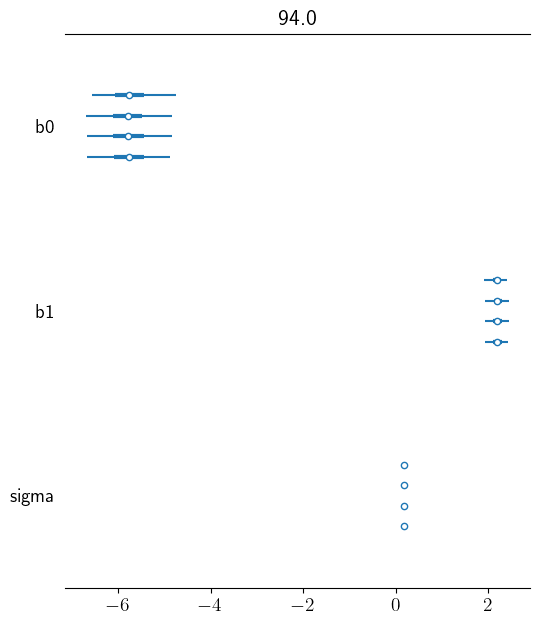

In [51]:
arviz.plot_forest(id)

(array([   6.,   65.,  423., 1503., 3115., 3037., 1456.,  343.,   48.,
           4.]),
 array([1.63003 , 1.745664, 1.861298, 1.976932, 2.092566, 2.2082  ,
        2.323834, 2.439468, 2.555102, 2.670736, 2.78637 ]),
 <BarContainer object of 10 artists>)

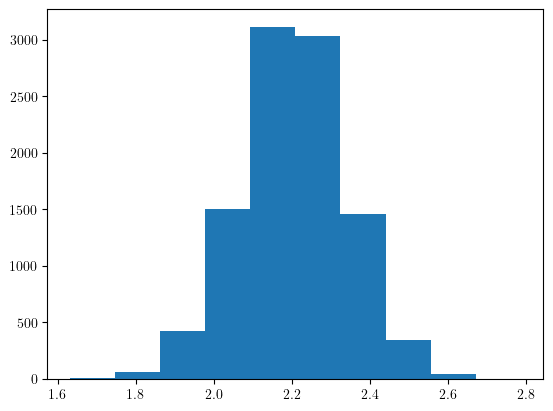

In [53]:
plt.hist(params['b1'])

(array([5.000e+00, 6.800e+01, 4.190e+02, 1.670e+03, 3.163e+03, 2.956e+03,
        1.319e+03, 3.380e+02, 5.900e+01, 3.000e+00]),
 array([-7.79939 , -7.386663, -6.973936, -6.561209, -6.148482, -5.735755,
        -5.323028, -4.910301, -4.497574, -4.084847, -3.67212 ]),
 <BarContainer object of 10 artists>)

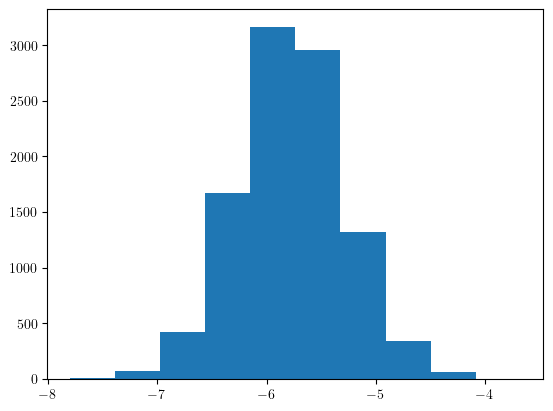

In [56]:
plt.hist(params['b0'])